# CartPole-v1 Policy Gradient Runner 

This notebook installs dependencies, runs a quick Actor-Critic training on CartPole-v1, and plots the returns inline. Upload the project files into the working directory or clone the repo before running.


In [1]:
pip install -q gymnasium[classic-control]


zsh:1: no matches found: gymnasium[classic-control]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# 1. Clone my repo
!git clone https://github.com/NikilTn/CMPE_260_hw3.git

%cd CMPE_260_hw3

In [2]:
#Install dependencies 
!pip install -r requirements.txt

In [ ]:
import sys
import os


sys.path.append(os.getcwd())


In [3]:
import gymnasium as gym
import numpy as np
import torch

from actor_critic import ActorCriticAgent
from config import get_config
from utils import set_seed


def train_actor_critic_quick(episodes=300, seed=42):
    """Train Actor-Critic (TD(0)) and return the trained agent."""
    config = get_config(
        "actor_critic",
        episodes=episodes,
        seed=seed,
        log_interval=max(episodes // 5, 1),
    )
    env = gym.make("CartPole-v1")
    set_seed(seed, env)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = ActorCriticAgent(state_dim, action_dim, config)

    returns = []
    for ep in range(1, episodes + 1):
        state, _ = env.reset(seed=seed)
        ep_ret = 0.0
        for _ in range(config.max_steps_per_episode):
            action, log_prob, value = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(agent.device)
            agent.update_step(state_tensor, log_prob, reward, next_state_tensor, done, value)
            ep_ret += reward
            state = next_state
            if done:
                break
        returns.append(ep_ret)
        if ep % max(episodes // 5, 1) == 0:
            print(f"Episode {ep}: return={ep_ret:.1f}, avg(50)={np.mean(returns[-50:]):.1f}")
    env.close()
    return agent, returns



In [4]:
# Train a quick Actor-Critic policy
agent, returns = train_actor_critic_quick(episodes=300, seed=42)
print(f"Final avg return (last 50): {np.mean(returns[-50:]):.1f}")


Episode 60: return=8.0, avg(50)=8.0
Episode 120: return=8.0, avg(50)=8.0
Episode 180: return=8.0, avg(50)=8.0
Episode 240: return=8.0, avg(50)=8.0
Episode 300: return=8.0, avg(50)=8.0
Final avg return (last 50): 8.0


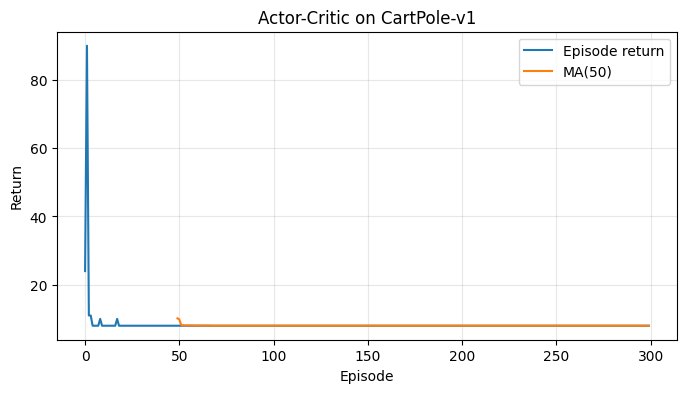

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(returns, label='Episode return')
if len(returns) > 10:
    window = min(50, len(returns))
    ma = np.convolve(returns, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(returns)), ma, label=f'MA({window})')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Actor-Critic on CartPole-v1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
